In [8]:
import numpy as np
from glob import glob
from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import os
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

There are 150 skin images.


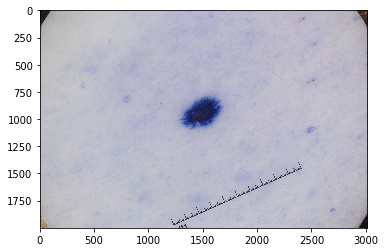

In [9]:
valid_files = np.array(glob("valid/*/*"))
print('There are %d skin images.' % len(valid_files))
img = cv2.imread(valid_files[0])
plt.imshow(img)

In [10]:
res50 = models.resnet50(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    res50 = res50.cuda()

In [11]:
num_workers = 0
batch_size = 20

transformTrain = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('train', transform = transformTrain)
valid_data = datasets.ImageFolder('valid', transform = transformTest)
test_data = datasets.ImageFolder('test', transform = transformTest)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)

In [12]:
res50 = models.resnet50(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    res50 = res50.cuda()

for param in res50.layer1.parameters():
    param.requires_grad = False
for param in res50.layer2.parameters():
    param.requires_grad = False
for param in res50.layer3.parameters():
    param.requires_grad = False
for param in res50.layer4.parameters():
    param.requires_grad = False

model_transfer = res50

fc1 = nn.Linear(model_transfer.fc.in_features, 3)
model_transfer.fc = fc1

if use_cuda:
    model_transfer = model_transfer.cuda()

In [13]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr = 0.01)

In [12]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    if use_cuda:
        model = model.cuda()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders[0]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders[1]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(trainloader.sampler)
        valid_loss = valid_loss/len(validloader.sampler)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation Loss has decreased. Saving the model.")
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
        
    # return trained model
    return model

model_transfer = train(10, [trainloader, validloader, testloader], model_transfer, 
                       optimizer_transfer, criterion_transfer, use_cuda, 
                       'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.699287 	Validation Loss: 0.771859
Validation Loss has decreased. Saving the model.
Epoch: 2 	Training Loss: 0.689382 	Validation Loss: 0.779783
Epoch: 3 	Training Loss: 0.677335 	Validation Loss: 0.724968
Validation Loss has decreased. Saving the model.
Epoch: 4 	Training Loss: 0.677297 	Validation Loss: 0.803991
Epoch: 5 	Training Loss: 0.667573 	Validation Loss: 0.693120
Validation Loss has decreased. Saving the model.
Epoch: 6 	Training Loss: 0.649973 	Validation Loss: 0.808735
Epoch: 7 	Training Loss: 0.657291 	Validation Loss: 0.723213
Epoch: 8 	Training Loss: 0.656938 	Validation Loss: 0.630705
Validation Loss has decreased. Saving the model.
Epoch: 9 	Training Loss: 0.644312 	Validation Loss: 0.660849
Epoch: 10 	Training Loss: 0.677156 	Validation Loss: 0.638179


<All keys matched successfully>

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders[2]):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test([trainloader, validloader, testloader], model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.698715


Test Accuracy: 68% (411/600)


In [14]:
class_names = [item.replace("_", " ") for item in trainloader.dataset.classes]

def triple_predict(img_path):
    image = Image.open(img_path).convert('RGB')
    
    img_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])   
    
    image = img_transform(image).unsqueeze(0)
    if(use_cuda):
        image = image.cuda()
    return [model_transfer(image).argmax(), class_names[model_transfer(image).argmax()]]

seborrheic keratosis


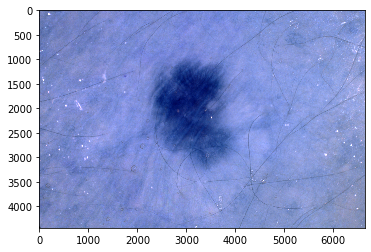

In [15]:
image_path = 'valid\\nevus\\ISIC_0014829.jpg'
print(triple_predict(image_path)[1])
img = cv2.imread(image_path)
plt.imshow(img)

In [18]:
cd data2

C:\Users\Jaiden Reddy\data2


In [19]:
num_workers = 0
batch_size = 20

transformTrain = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('train', transform = transformTrain)
valid_data = datasets.ImageFolder('valid', transform = transformTest)
test_data = datasets.ImageFolder('test', transform = transformTest)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)

In [20]:
res50 = models.resnet50(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    res50 = res50.cuda()

for param in res50.layer1.parameters():
    param.requires_grad = False
for param in res50.layer2.parameters():
    param.requires_grad = False
for param in res50.layer3.parameters():
    param.requires_grad = False
for param in res50.layer4.parameters():
    param.requires_grad = False

model_transfer = res50

fc1 = nn.Linear(model_transfer.fc.in_features, 2)
model_transfer.fc = fc1

if use_cuda:
    model_transfer = model_transfer.cuda()

In [41]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    if use_cuda:
        model = model.cuda()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders[0]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders[1]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(trainloader.sampler)
        valid_loss = valid_loss/len(validloader.sampler)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation Loss has decreased. Saving the model.")
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
        
    # return trained model
    return model

model_transfer = train(10, [trainloader, validloader, testloader], model_transfer, 
                       optimizer_transfer, criterion_transfer, use_cuda, 
                       'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.554695 	Validation Loss: 0.633737
Validation Loss has decreased. Saving the model.
Epoch: 2 	Training Loss: 0.554392 	Validation Loss: 0.630346
Validation Loss has decreased. Saving the model.


KeyboardInterrupt: 

In [42]:
test([trainloader, validloader, testloader], model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.570410


Test Accuracy: 80% (484/600)
